In [1]:
%load_ext autoreload
%autoreload 2

%autosave 10

Autosaving every 10 seconds


In [19]:
import sys
sys.path.append('../code/') # Make code in "tools" folder visible to python interpreter

import os
import warnings

import numpy as np
from scipy import signal

import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_palette("Set2")
%matplotlib widget

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Palatino"],
    }
)

import torch
from torchinfo import summary

from matplotlib.colors import ListedColormap
#plt.rcParams["image.cmap"] = ListedColormap(sns.color_palette(as_cmap=True))

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

from tools.data_generation import DataGenerator
from tools.data_processing import Dataset
from tools.svm import SVMClassifier
from tools.patient_data import PatDataset, PatID, Stim, Task
from tools.nn_training import Module

In [5]:
Fs = 2048

# Generate data:


In [7]:
beta_gamma_cfg = {
    "betas": None,
    "gammas": None,
    "beta_sharpness": None,
    "phase": None,
    "pac": None,
    "cross_pac": None,
    "phase_shift": [0.3, 0.7],
    "burst_length": None,
}

In [11]:
data = DataGenerator(beta_gamma_cfg, 0.7, Fs=Fs, T=1200)
dataset = Dataset(data.signals, data.label, Fs, data_aug_intensity = 0.2, tf_transform=True, quantile_transform=False, feat_ar = True, ar_len = 10, window_length = 0.5, hop_size = 0.35, fold_id=0)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.1s finished


In [9]:
start_idx = np.where(np.diff(data.label)>0)[0]
end_idx = np.where(np.diff(data.label)<0)[0]

In [10]:
durations = (end_idx - start_idx) / 2048.0
durations.mean(), durations.std()

(13.189655172413794, 8.024653599896716)

# Classify:


### SVM:

In [16]:
cls = SVMClassifier(
        dataset.X_features_train_scaled,
        dataset.X_features_valid_scaled,
        dataset.y_train,
        dataset.y_valid,
    )

cls.classify()

(1.0, 0.48380597014925375)

In [14]:
cls = SVMClassifier(
        dataset.X_features_ar_train,
        dataset.X_features_ar_valid,
        dataset.y_ar_train,
        dataset.y_ar_valid,
    )

cls.classify()

(0.5, 0.5)

In [15]:
def score_module(module, train_dataloader, valid_dataloader, accelerator='gpu', device=[0]):

    trainer = pl.Trainer(
        logger=True,
        accelerator=accelerator,
        devices=device,
        callbacks=[
            ModelCheckpoint(
                save_weights_only=True,
                mode="max",
                monitor="valid/bal_acc",
                save_top_k=1,
            )
        ],
        max_epochs=150,
    )
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore", message="y_pred contains classes not in y_true"
        )
        trainer.fit(module, train_dataloader, valid_dataloader)
        module = module.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
        train_score = trainer.validate(module, train_dataloader)[0]["valid/bal_acc"]
        valid_score = trainer.validate(module, valid_dataloader)[0]["valid/bal_acc"]

    return train_score, valid_score


In [25]:
model_name = "cnn1d"
model_hparams = {'n_channels': dataset.timeseries.shape[0], 'compress': True, 'depth':7, 'ks':25}
# model_hparams = {'n_channels': dataset.timeseries.shape[0], 'n_samples': dataset.X_train[0].shape[-1], 'depth':7}
opt_name = "Adam"
opt_hparams = {'lr': 1e-3, "weight_decay": 0.0}

module = Module(model_name, model_hparams, opt_name, opt_hparams, use_mixup=True)

In [28]:
summary(module)

Layer (type:depth-idx)                   Param #
Module                                   --
├─CNN1d: 1-1                             --
│    └─Sequential: 2-1                   --
│    │    └─BatchNorm1d: 3-1             4
│    │    └─Compressor: 3-2              2
│    │    └─BatchNorm1d: 3-3             4
│    │    └─Conv1d: 3-4                  2,295
│    │    └─SiLU: 3-5                    --
│    │    └─BatchNorm1d: 3-6             90
│    │    └─Compressor: 3-7              45
│    │    └─Conv1d: 3-8                  50,670
│    │    └─SiLU: 3-9                    --
│    │    └─AvgPool1d: 3-10              --
│    │    └─BatchNorm1d: 3-11            90
│    │    └─Compressor: 3-12             45
│    │    └─Conv1d: 3-13                 50,670
│    │    └─SiLU: 3-14                   --
│    │    └─AvgPool1d: 3-15              --
│    │    └─BatchNorm1d: 3-16            90
│    │    └─Compressor: 3-17             45
│    │    └─Conv1d: 3-18                 50,670
│    │    └─SiL

In [27]:
score_module(module, dataset.train_dataloader(), dataset.valid_dataloader())

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name        | Type              | Params
--------------------------------------------------
0 | model       | CNN1d             | 307 K 
1 | loss_module | BCEWithLogitsLoss | 0     
--------------------------------------------------
307 K     Trainable params
0         Non-trainable params
307 K     Total params
1.229     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/fernando/anaconda3/envs/test_env_3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/fernando/anaconda3/envs/test_env_3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/fernando/anaconda3/envs/test_env_3/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training bat

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/fernando/anaconda3/envs/test_env_3/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/fernando/anaconda3/envs/test_env_3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/home/fernando/anaconda3/envs/test_env_3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) in the `DataLoader` init to i

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      valid/bal_acc         0.7386422488566032
       valid/loss           0.5474483370780945
       valid/score          1.1911939117785089
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/fernando/anaconda3/envs/test_env_3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      valid/bal_acc         0.6248952522103178
       valid/loss           0.7863929867744446
       valid/score          0.8385022654358733
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


(0.7386422488566032, 0.6248952522103178)

## Estimate FLOP count:

In [20]:
module = Module.with_defaults_1d(1,**{'ks':35, 'depth':7, 'n_hidden':35})

summary(module.model, input_size=(1,1,1024)).total_mult_adds / 10e6

8.779733

Text(0, 0.5, '[log] \\#GFLOP / output')

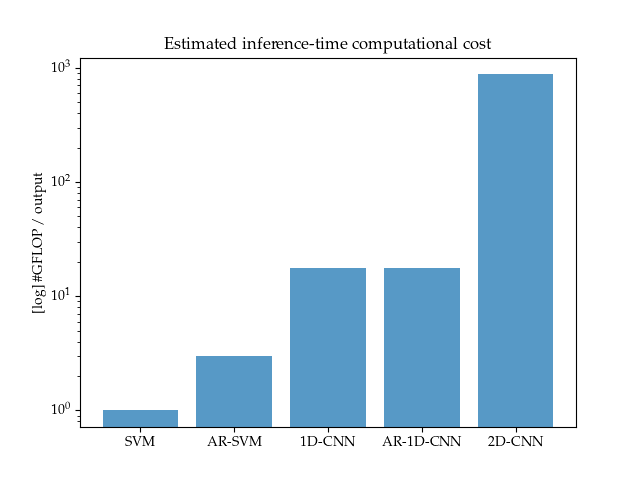

In [21]:
fig, ax = plt.subplots()

ax.bar(['SVM', 'AR-SVM', '1D-CNN', 'AR-1D-CNN', '2D-CNN'], [1, 3, 2*8.78, 2*8.78, 2*187.6+500], alpha=0.75)
ax.set_yscale('log')

ax.set_title('Estimated inference-time computational cost')
ax.set_ylabel('[log] \#GFLOP / output')